### Import libraries

In [3]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [4]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load the dataset

In [50]:
(X_train_original, y_train), (X_test_original, y_test) = mnist.load_data()

X = tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.reshape(X_train_original, X_train_original.shape + (1, )))).numpy()
X_test = tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.reshape(X_test_original, X_test_original.shape + (1, )))).numpy()
y = tfk.utils.to_categorical(y_train, 10)
y_test = tfk.utils.to_categorical(y_test, 10)

#printing the shapes of the vectors 
print('X_train: ' + str(X.shape))
print('Y_train: ' + str(y.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28, 3)
Y_train: (60000, 10)
X_test:  (10000, 28, 28, 3)
Y_test:  (10000, 10)


### Split the dataset (circa 70-15-15)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1666666)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28, 3)
(50000, 28, 28, 3) (50000, 10)
(10000, 28, 28, 3) (10000, 10)
(10000, 28, 28, 3) (10000, 10)


### Show some data

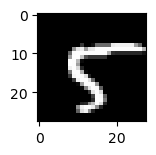

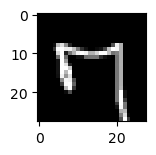

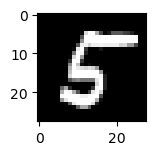

In [52]:
for i in range(3):  
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.show()

### Models metadata

In [53]:
input_shape = X_train.shape[1:]
image_shape = input_shape[:-1]
batch_size = 256
epochs = 200
labels = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}

# First attempt: use a Neural Network as classifier

Model: "standard_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 3)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 2352)              0         
                                                                 
 classifier (Dense)          (None, 32)                75296     
                                                                 
 classifier_dropout (Dropout  (None, 32)               0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                330       
                                                                 
Total params: 75,626
Trainable params: 75,626
Non-trainable params: 0
________________________________________________

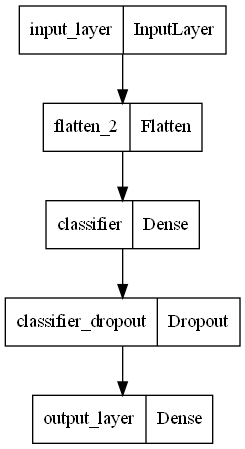

In [54]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = tfkl.Flatten()(input_layer)
    
    x = tfkl.Dense(
        units = 32,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = 10, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'standard_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

standard_model = build_model(input_shape)
standard_model.summary()
tfk.utils.plot_model(standard_model)

### Train the model

In [55]:
standard_history = standard_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/200
196/196 [==============================] - 1s 3ms/step - loss: 4.4491 - accuracy: 0.1994 - val_loss: 1.9201 - val_accuracy: 0.3024
Epoch 2/200
196/196 [==============================] - 1s 3ms/step - loss: 1.9709 - accuracy: 0.2678 - val_loss: 1.7390 - val_accuracy: 0.3590
Epoch 3/200
196/196 [==============================] - 1s 3ms/step - loss: 1.9126 - accuracy: 0.2902 - val_loss: 1.7338 - val_accuracy: 0.3991
Epoch 4/200
196/196 [==============================] - 1s 3ms/step - loss: 1.8498 - accuracy: 0.3153 - val_loss: 1.6122 - val_accuracy: 0.4172
Epoch 5/200
196/196 [==============================] - 1s 3ms/step - loss: 1.7754 - accuracy: 0.3445 - val_loss: 1.5131 - val_accuracy: 0.4693
Epoch 6/200
196/196 [==============================] - 1s 3ms/step - loss: 1.7309 - accuracy: 0.3612 - val_loss: 1.3936 - val_accuracy: 0.4953
Epoch 7/200
196/196 [==============================] - 1s 3ms/step - loss: 1.6502 - accuracy: 0.3984 - val_loss: 1.2614 - val_accuracy: 0.5851

# Second attempt: use a CNN built by scratch

Model: "convolutional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 64)        1792      
                                                                 
 mp1 (MaxPooling2D)          (None, 14, 14, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 128)       73856     
                                                                 
 mp2 (MaxPooling2D)          (None, 7, 7, 128)         0         
                                                                 
 Conv3 (Conv2D)              (None, 7, 7, 256)         295168    
                                                                 
 gap (GlobalAveragePooling2D  (None, 256)      

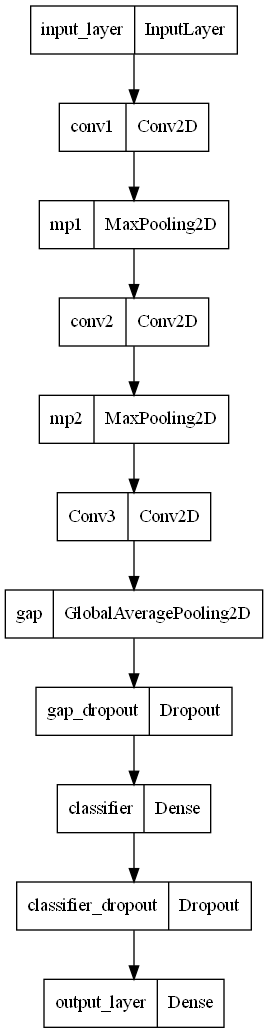

In [56]:
def build_conv_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = 10, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'convolutional_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

conv_model = build_conv_model(input_shape)
conv_model.summary()
tfk.utils.plot_model(conv_model)

### Train the model

In [57]:
# Train the model
conv_history = conv_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/200
196/196 [==============================] - 4s 18ms/step - loss: 9.7875 - accuracy: 0.5421 - val_loss: 0.2543 - val_accuracy: 0.9307
Epoch 2/200
196/196 [==============================] - 3s 17ms/step - loss: 0.3585 - accuracy: 0.8887 - val_loss: 0.1205 - val_accuracy: 0.9647
Epoch 3/200
196/196 [==============================] - 3s 17ms/step - loss: 0.2127 - accuracy: 0.9350 - val_loss: 0.0985 - val_accuracy: 0.9707
Epoch 4/200
196/196 [==============================] - 3s 17ms/step - loss: 0.1622 - accuracy: 0.9502 - val_loss: 0.0789 - val_accuracy: 0.9755
Epoch 5/200
196/196 [==============================] - 3s 17ms/step - loss: 0.1281 - accuracy: 0.9608 - val_loss: 0.0641 - val_accuracy: 0.9814
Epoch 6/200
196/196 [==============================] - 4s 18ms/step - loss: 0.1115 - accuracy: 0.9652 - val_loss: 0.0669 - val_accuracy: 0.9802
Epoch 7/200
196/196 [==============================] - 3s 18ms/step - loss: 0.0945 - accuracy: 0.9713 - val_loss: 0.0544 - val_accuracy:

### Plot training results

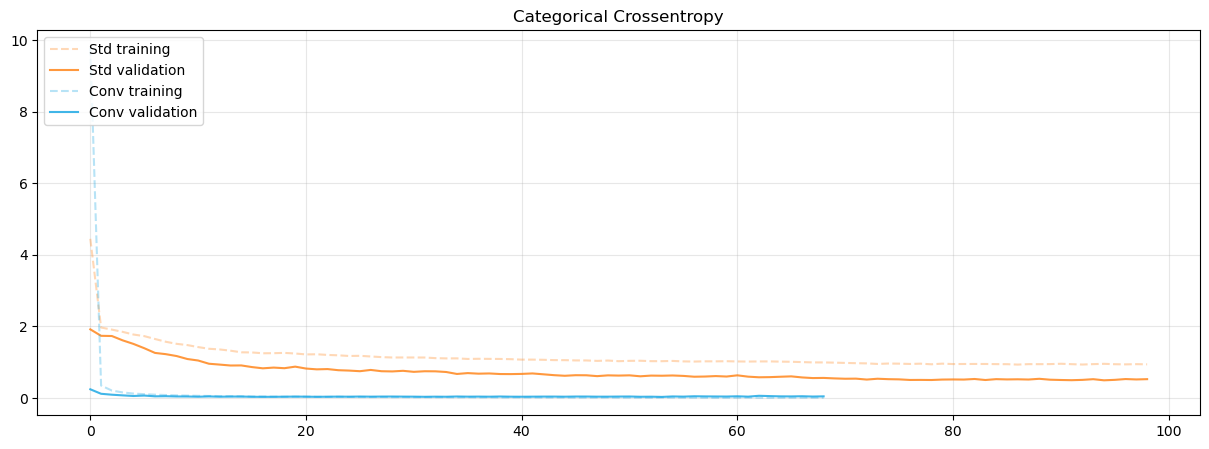

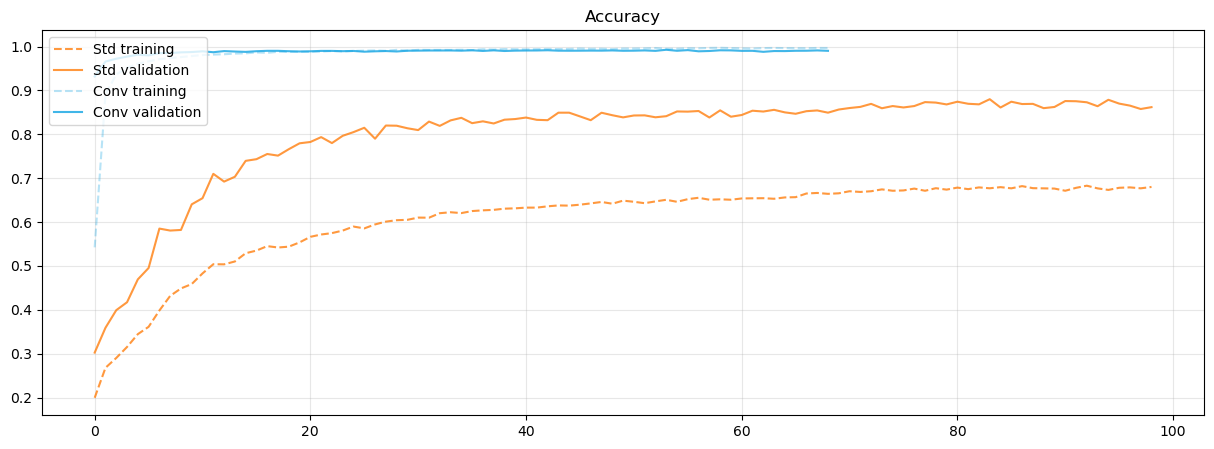

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.plot(conv_history['loss'], label='Conv training', alpha=.3, color='#12a4e3', linestyle='--')
plt.plot(conv_history['val_loss'], label='Conv validation', alpha=.8, color='#12a4e3')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.plot(conv_history['accuracy'], label='Conv training', alpha=.3, color='#12a4e3', linestyle='--')
plt.plot(conv_history['val_accuracy'], label='Conv validation', alpha=.8, color='#12a4e3')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

313/313 [==============================] - 0s 1ms/step


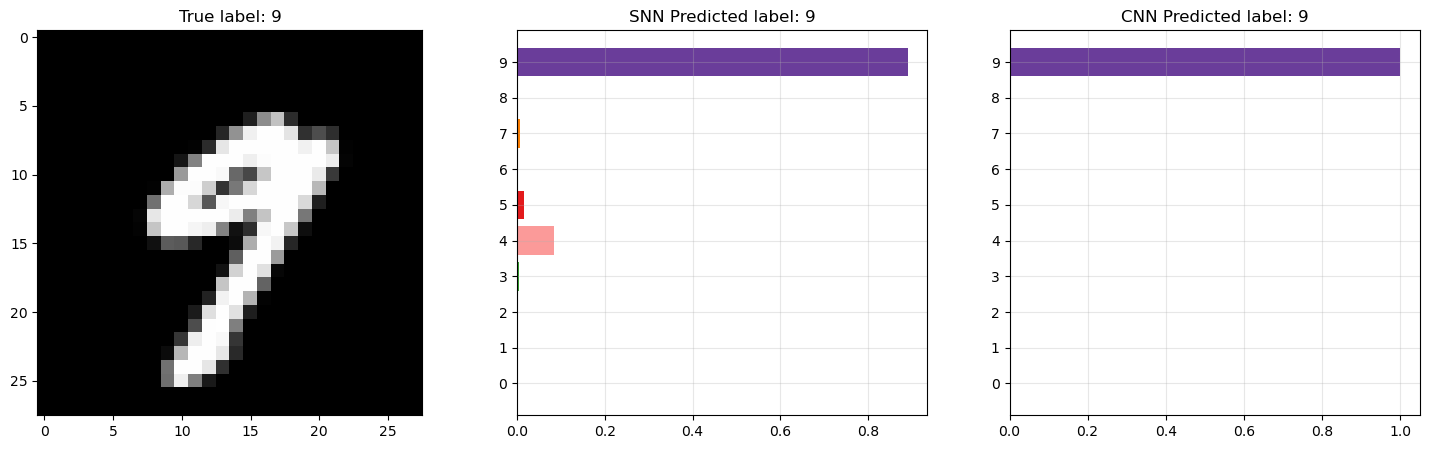

In [ ]:
# Predict the test set
standard_predictions = standard_model.predict(X_test)
conv_predictions = conv_model.predict(X_test)

# Plot the target images and the predictions
prediction_index = 20

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(y_test[prediction_index])])
ax2.barh(list(labels.values()), standard_predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('SNN Predicted label: '+labels[np.argmax(standard_predictions[prediction_index])])
ax2.grid(alpha=.3)
ax3.barh(list(labels.values()), conv_predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax3.set_title('CNN Predicted label: '+labels[np.argmax(conv_predictions[prediction_index])])
ax3.grid(alpha=.3)
plt.show()

Accuracy: 0.8838
Precision: 0.8829
Recall: 0.8813
F1: 0.8816


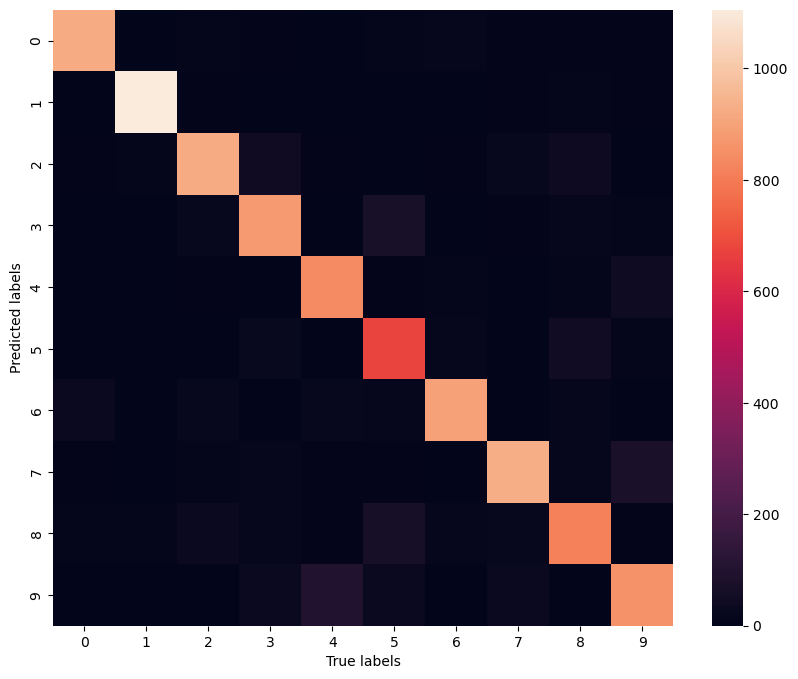

In [ ]:
# Compute the confusion matrix
predictions = standard_predictions  # Change this to "standard" or "conv" to see different results
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the obtained model (only if it represents a real improvement)

In [ ]:
restored_model = tfk.models.load_model('StandardModel')
restored_loss, restored_acc = restored_model.evaluate(X_test, y_test, verbose=2)  
loss, acc = conv_model.evaluate(X_test, y_test, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    conv_model.save('StandardModel')
else:
    conv_model = restored_model
    print("Model restored!")

313/313 - 1s - loss: 0.0232 - accuracy: 0.9923 - 733ms/epoch - 2ms/step
313/313 - 1s - loss: 0.0359 - accuracy: 0.9916 - 635ms/epoch - 2ms/step
Model restored!


### Lets try on your image

1/1 [==============================] - 0s 56ms/step


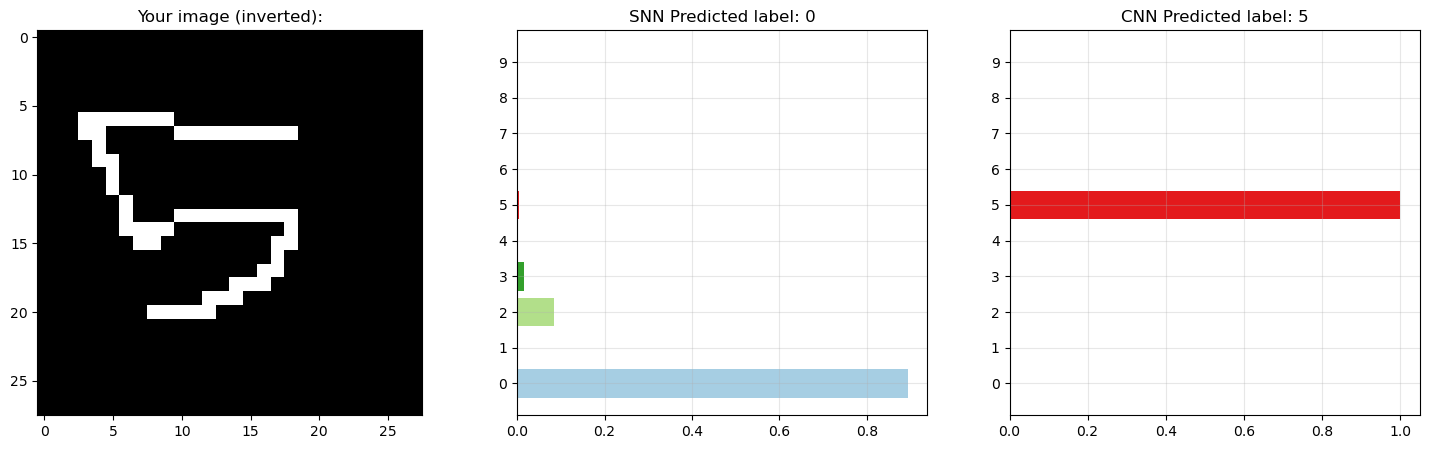

In [ ]:
# uncomment this line if you want to use the saved model as the conv_model
#conv_model = tfk.models.load_model('StandardModel')

with Image.open("test_image.png") as img:
    rgb_image = img.convert('RGB')
    x_to_test = np.expand_dims(rgb_image, axis=0)
    x_to_test = 255 - x_to_test
    standard_prediction = standard_model.predict(x_to_test) 
    conv_prediction = conv_model.predict(x_to_test)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(18,5)
    ax1.imshow(np.reshape(x_to_test, input_shape))
    ax1.set_title('Your image (inverted):')
    ax2.barh(list(labels.values()), np.reshape(standard_prediction, (10, )), color=plt.get_cmap('Paired').colors)
    ax2.set_title('SNN Predicted label: '+ labels[np.argmax(standard_prediction)])
    ax2.grid(alpha=.3)
    ax3.barh(list(labels.values()), np.reshape(conv_prediction, (10, )), color=plt.get_cmap('Paired').colors)
    ax3.set_title('CNN Predicted label: '+ labels[np.argmax(conv_prediction)])
    ax3.grid(alpha=.3)
    plt.show()

# Third attempt: enhance the SNN using Data Augmentation

##### ImageDataGenerator allows to perform data augmentation

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```

### Lets define the transformations we're interesetd in

Transform: {'theta': -5.0183952461055, 'tx': 0, 'ty': 2, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}


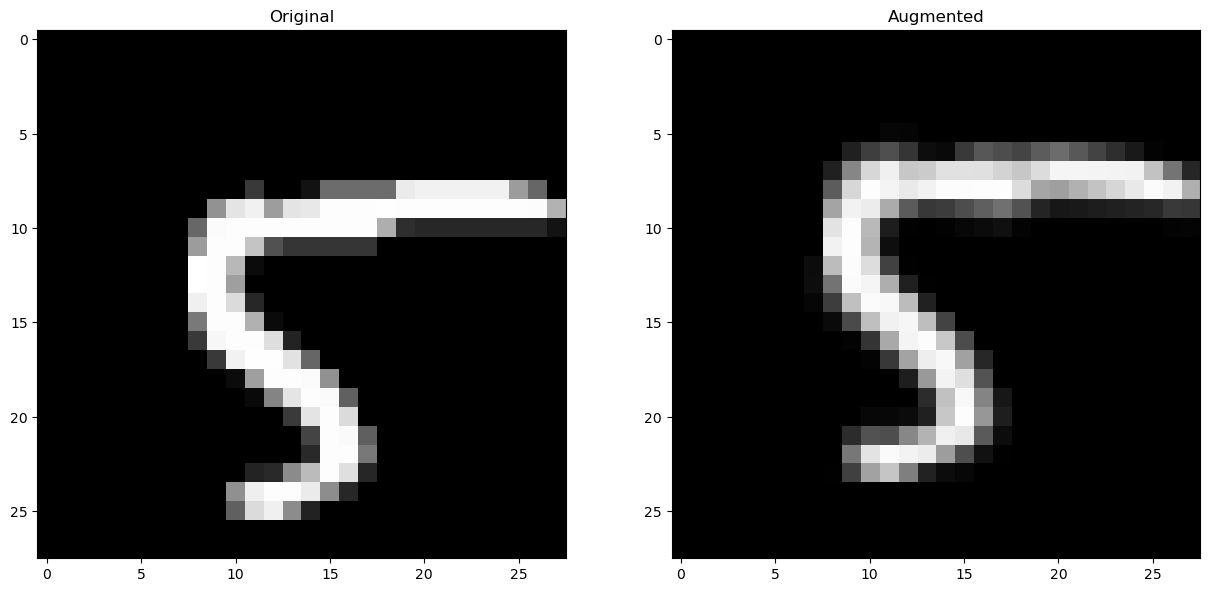

In [ ]:
# Combine multiple transformations
shift_range = 4
gen = ImageDataGenerator(rotation_range=20,
                         height_shift_range=shift_range,
                         width_shift_range=shift_range,
                         fill_mode='constant')

# Get random transformation
image = X_train[0]
t = gen.get_random_transform(img_shape=image_shape, seed=seed)
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# Plot original and augmented image
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

### Lets create the real generator and analyze a single sample batch

(2, 28, 28, 3)
(2, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


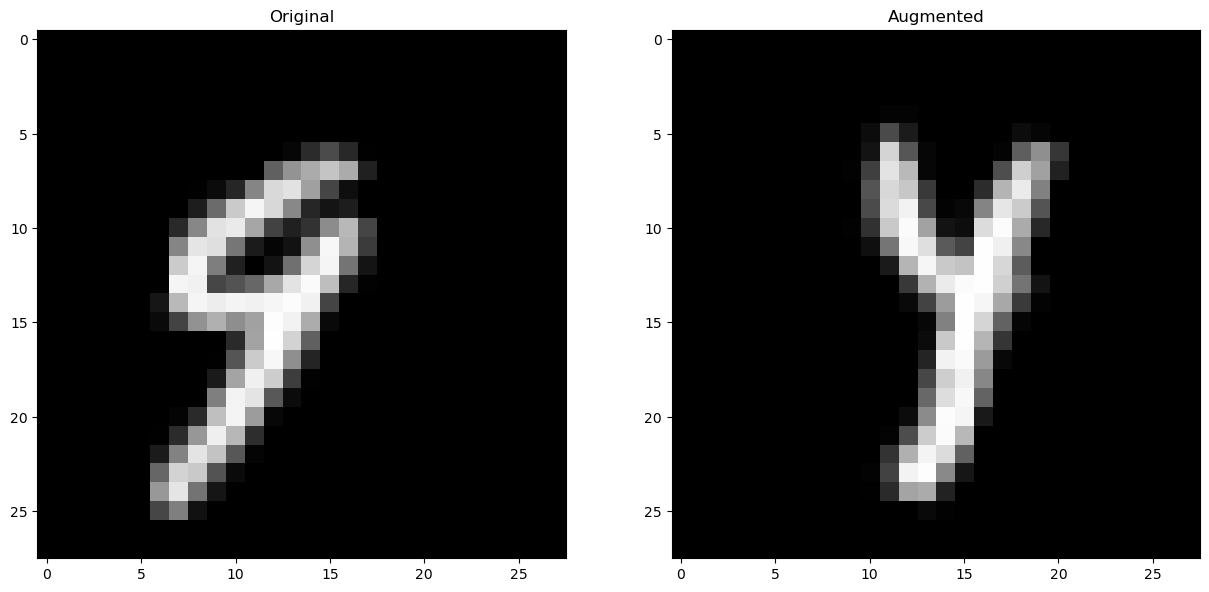

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow()' method
train_gen = gen.flow(X_train, 
                     y_train,
                     batch_size=16,
                     seed=seed)

# Get sample batch
batch = next(train_gen)
print(batch[0].shape)
print(batch[1].shape)

image1 = batch[0][0]
print(batch[1][0])
image2 = batch[0][1]
print(batch[1][1])

fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image1))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(image2))
ax[1].set_title("Augmented")
plt.show()

### Training with data augmentation

In [ ]:
# Re-train the model (same effect of doubling the dataset size: calling .fit() multiple times trains the model incrementally)
history = standard_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)],
).history

Epoch 1/200
25000/25000 [==============================] - 54s 2ms/step - loss: 2.3146 - accuracy: 0.1157 - val_loss: 2.2338 - val_accuracy: 0.1124
Epoch 2/200
25000/25000 [==============================] - 53s 2ms/step - loss: 2.2963 - accuracy: 0.1104 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 3/200
25000/25000 [==============================] - 54s 2ms/step - loss: 2.3019 - accuracy: 0.1120 - val_loss: 2.3018 - val_accuracy: 0.1044
Epoch 4/200
25000/25000 [==============================] - 54s 2ms/step - loss: 2.3026 - accuracy: 0.1118 - val_loss: 2.3012 - val_accuracy: 0.1124
Epoch 5/200
25000/25000 [==============================] - 53s 2ms/step - loss: 2.3021 - accuracy: 0.1121 - val_loss: 2.3016 - val_accuracy: 0.1124
Epoch 6/200
25000/25000 [==============================] - 53s 2ms/step - loss: 2.3046 - accuracy: 0.1098 - val_loss: 2.2967 - val_accuracy: 0.1124
Epoch 7/200
25000/25000 [==============================] - 52s 2ms/step - loss: 2.3097 - accuracy: 0.1112 - val_

KeyboardInterrupt: 

### Lets compare to previous results

In [ ]:
# Predict the test set
standard_predictions = standard_model.predict(X_test)

# Compute the confusion matrix
predictions = standard_predictions
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Fourth attempt: find a way to produce a specified amount of augmented images, include them in the training set and then repeat the training from zero

### Inspect the targets distribution

In [ ]:
classes, counts = np.unique(np.fromiter([np.argmax(x) for x in y], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Lets suppose we want a specified amount of sample for each class

In [ ]:
desired_amount = 7000

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(classes)):
    ref_list.append([])
  
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

for i in range(0, len(classes)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(classes))
    print(f'Computing {to_produce} augmented images for target {i} -> {target}')
    aug_targets_i = np.full((length, len(classes)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

X_aug = np.concatenate((X, np.array(aug_samples)))
y_aug = np.concatenate((y, np.array(aug_targets)))

### Lets inspect now our dataset distribution

In [ ]:
classes, counts = np.unique(np.fromiter([np.argmax(x) for x in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### We need to re-perform the train-validation split and then repeat the training

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

In [ ]:
aug_model = build_conv_model(input_shape)

aug_history = aug_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

### Comparing the trainings and results

In [ ]:
# Predict the test set
aug_predictions = aug_model.predict(X_test)

# Compute the confusion matrix
predictions = aug_predictions
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()